In [1]:
%matplotlib inline

In [13]:
import numpy as np
from scipy import sparse
from scipy.spatial import Delaunay, Voronoi, voronoi_plot_2d
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib import colors as cols
#import serpentine as sp
import skimage.draw
import os
import cv2
from matplotlib.patches import Rectangle

np.random.seed(0)

In [6]:
def add_points_infinity(points, data, shape):
    # Add points at infinity
    points = np.concatenate([points,
                            np.array([[-1.5*shape[0], -1.5*shape[1]], [-1.5*shape[0], 2.5*shape[1]], [2.5*shape[0], -1.5*shape[1]], [2.5*shape[0], 2.5*shape[1]]], dtype=points.dtype)])

    data = np.concatenate([data,
                           np.zeros((points.shape[0] - data.shape[0], data.shape[1]), dtype=data.dtype)])
    return points, data

In [7]:
triangular=True

dense_A = np.loadtxt("demos/A.csv")
A = np.copy(dense_A)
if triangular is True:
    A -= np.tril(A)

A = sparse.csr_matrix(A)

dense_B = np.loadtxt('demos/B.csv')
B = np.copy(dense_B)
if triangular is True:
    B -= np.tril(B)

B = sparse.csr_matrix(B)

# The input of the binning function, a list of csr_matrices and a threshold
Q = [A, B]
threshold = 20

# Find all points
S = sparse.coo_matrix(sum(Q))
S.sum_duplicates()

# The coo-matrix that we are really going to use
points = np.stack((S.row, S.col)).T
data = np.fromiter(
    (M[i,j] for M in Q for i,j in points)
    , dtype=S.dtype).reshape(2, points.shape[0]).T

points, data = add_points_infinity(points, data, A.shape)

In [8]:
# Find the Delaunay graph
tri = Delaunay(points)
indptr, neighv = tri.vertex_neighbor_vertices

In [9]:
# Define a custom-made colormap for viewing logratios

minima = 0
maxima = np.percentile(S.data, 50)


norm = mpl.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Reds)
mapper_ratio = cm.ScalarMappable(norm=norm, cmap=cm.seismic)

colors = [
    (120.0 / 350 / 2, 180.0 / 350 / 2, 230.0 / 350 / 2),
    (179.0 / 255, 205.0 / 255, 227.0 / 255) ] + [(1,1,1)] + [
    (251.0 / 255, 180.0 / 255, 174.0 / 255),
    (248.0 / 350 / 2, 120.0 / 350 / 2, 109.0 / 350 / 2),
]
cmap_name = "pastelpentine"
custom_cm = cols.LinearSegmentedColormap.from_list(cmap_name, colors, N=21)

s = plt.cm.ScalarMappable()
#s.set_clim(0., 20.)
s.set_clim(-2, 2)
s.set_cmap(custom_cm)
#s.set_array(range(-5,5))

In [10]:
def clip_polygon(subjectPolygon, clipPolygon):
   def inside(p):
      return(cp2[0]-cp1[0])*(p[1]-cp1[1]) > (cp2[1]-cp1[1])*(p[0]-cp1[0])
      
   def computeIntersection():
      dc = [ cp1[0] - cp2[0], cp1[1] - cp2[1] ]
      dp = [ s[0] - e[0], s[1] - e[1] ]
      n1 = cp1[0] * cp2[1] - cp1[1] * cp2[0]
      n2 = s[0] * e[1] - s[1] * e[0] 
      n3 = 1.0 / (dc[0] * dp[1] - dc[1] * dp[0])
      return [(n1*dp[0] - n2*dc[0]) * n3, (n1*dp[1] - n2*dc[1]) * n3]

   outputList = subjectPolygon
   cp1 = clipPolygon[-1]
   
   for clipVertex in clipPolygon:
      cp2 = clipVertex
      inputList = outputList
      outputList = []
      if len(inputList) == 0:
         return np.array([])
      s = inputList[-1]

      for subjectVertex in inputList:
         e = subjectVertex
         if inside(e):
            if not inside(s):
               outputList.append(computeIntersection())
            outputList.append(e)
         elif inside(s):
            outputList.append(computeIntersection())
         s = e
      cp1 = cp2
   return(np.array(outputList))

In [11]:
def rasterized_serpentine(points, sparse_data, shape, triangular):

    """Computes a rasterized image of the Voronoi diagram of the points.
    """
    vor2 = Voronoi(points)

    if triangular is False:
        clipper = np.array([[shape[0]-.5,shape[1]-.5], [-.5,shape[1]-.5] , [-.5,-.5], [shape[0]-.5, -.5]])
    else:
        clipper = np.array([[shape[0]-.5,shape[1]-.5], [-.5,shape[1]-.5] , [-.5,-.5]])
    
    rasterized_img = np.zeros(shape) * np.nan

    for r in range(len(vor2.point_region)): 
        region = vor2.regions[vor2.point_region[r]] 
        if not -1 in region: 
            poly = np.array([vor2.vertices[i] for i in region])
            poly = clip_polygon(poly, clipper)

            if len(poly) > 0:            # Magic happens here
                rr, cc = skimage.draw.polygon(poly[:,0], poly[:,1], rasterized_img.shape)
                rasterized_img[rr, cc] = sparse_data.data[r]

    return rasterized_img.T

rasterize_serpentine = rasterized_serpentine

/tmp/ipykernel_249834/2032101807.py:2: RuntimeWarning: divide by zero encountered in divide
  raw_logratio = np.log2((data1)/(data2))
/tmp/ipykernel_249834/2032101807.py:2: RuntimeWarning: invalid value encountered in divide
  raw_logratio = np.log2((data1)/(data2))
/tmp/ipykernel_249834/2032101807.py:2: RuntimeWarning: divide by zero encountered in log2
  raw_logratio = np.log2((data1)/(data2))


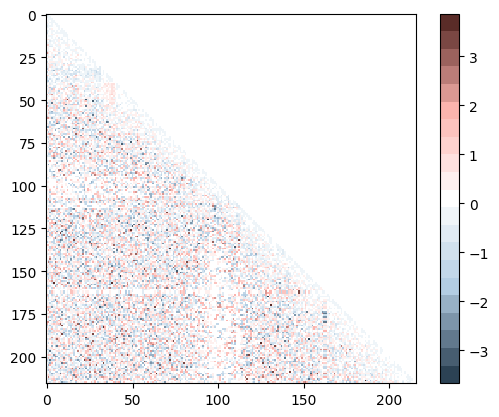

In [14]:
data1, data2 = data.T
raw_logratio = np.log2((data1)/(data2))

raw_logratio -= np.nanmean(raw_logratio[~np.isinf(raw_logratio)])

raw_rasterized_logratio = rasterized_serpentine(points, raw_logratio, A.shape, triangular)

#raw_rasterized_logratio[np.triu_indices(raw_rasterized_logratio.shape[0])] = raw_rasterized_logratio.T[np.triu_indices(raw_rasterized_logratio.shape[0])]

plt.imshow(raw_rasterized_logratio, cmap=custom_cm, interpolation='none')

plt.colorbar()

In [15]:

# Find neighbors from the Delaunay graph
# convert it to a list of sets

def voroserp(old_points, old_data, shape, indptr, neighv, threshold = 20, maxiter = 1000, imgprefix=None, triangular=False):

    if imgprefix is not None:
        if not os.path.exists(imgprefix):
            os.makedirs(imgprefix)

    points = old_points.copy()
    data = old_data.copy()

    neigh = []
    for k in range(indptr.size - 1):
        neigh.append(set(neighv[indptr[k]:indptr[k+1]]))

    # Counters
    previous_existent = points.shape[0]
    current_existent = 0

    iteration_count = 0

    removed = np.zeros(points.shape[0], dtype=bool)

    bordermask_more = np.logical_or(points.T[0] > shape[0], points.T[1] > shape[1])
    bordermask_less = np.logical_or(points.T[0] < 0, points.T[1] < 0)
    bordermask = np.logical_or(bordermask_more, bordermask_less)

    removed[bordermask] = True

    while current_existent != previous_existent:
        current_existent = previous_existent

        for k in np.random.permutation(range(points.shape[0])):

            # Is it still there,  
            if removed[k] == False and np.any(data[k] < threshold):

                if imgprefix is not None:

                    # Restore border mask for plotting
                    removed[bordermask] = False

                    pointsimg = points[removed == False].copy()
                    dataimg = data[removed == False].copy()
                    tri_img = Delaunay(pointsimg)


                    removed[bordermask] = True

                    img = rasterized_serpentine(pointsimg, dataimg[:,0], shape, triangular)
                    #img += img.T - np.diag(img.diagonal())
                    plt.imshow(img, cmap='Reds', interpolation='none', vmin = 0, vmax=threshold) 
                    plt.colorbar()
                   
                    # plot points coordinates from points[k] with green markers
                    #plt.scatter(pointsimg[:,0], pointsimg[:,1], c='b', s=5)

                    plt.triplot(pointsimg[:,0], pointsimg[:,1], tri_img.simplices, markersize=1, linewidth=.5)
                    plt.scatter([points[k][0]], [points[k][1]], c='g', s=10)

                    plt.xlim((-.5, shape[0] - .5))
                    plt.ylim((shape[1] - .5, -.5))

                    plt.axis('off')
                    plt.gca().add_patch( Rectangle((-.5, -.5),
                                            19.9, 19.9,
                                            fc ='none', 
                                            ec ='darkblue',
                                            lw = 1) )

                    plt.savefig(os.path.join(imgprefix, "serpentine_{:03d}_abefore.png".format(iteration_count)))
                    plt.close()
                # find first neighbors indices
                fn = np.fromiter(neigh[k], dtype=np.int32)
                fn = fn[removed[fn] == False]

                # calculate their distances
                distances = ((points[fn] - points[k])**2).sum(axis=1)

                # probability ansatz from distances for merging
                prob = np.cumsum( 1./(distances + np.finfo(float).eps) )
                prob /= prob[-1]

                # chose index of merger
                fuse = fn[np.argmax(prob > np.random.rand()) - 1]

                # move merger on the weighted mean position
                a = data[fuse].sum()
                b = data[k].sum()
                points[fuse] = (points[fuse] * a + points[k] * b) / (a+b)


                # Merge neighbours (and remove self)
                # calculate 
                neigh[fuse].remove(k)
                neigh[k].remove(fuse)
                neigh[fuse].update(neigh[k])

                # Update neighbours of merged
                for nneigh in neigh[k]:
                    neigh[nneigh].remove(k)
                    neigh[nneigh].add(fuse)

                # Update counting in the matrix
                data[fuse] = data[fuse] + data[k]
                data[k] = 0

                removed[k] = True

                current_existent -= 1

                if imgprefix is not None:

                    # Restore border mask for plotting
                    removed[bordermask] = False

                    pointsimg = points[removed == False].copy()
                    dataimg = data[removed == False].copy()
                    tri_img = Delaunay(pointsimg)


                    removed[bordermask] = True

                    img = rasterized_serpentine(pointsimg, dataimg[:,0], shape, triangular)
                    #img += img.T - np.diag(img.diagonal())
                    plt.imshow(img, cmap='Reds', interpolation='none', vmin = 0, vmax=threshold) 
                    plt.colorbar()
                   
                    # plot points coordinates from points[k] with green markers
                    #plt.scatter(pointsimg[:,0], pointsimg[:,1], c='b', s=5)
                    
                    plt.triplot(pointsimg[:,0], pointsimg[:,1], tri_img.simplices, markersize=1, linewidth=.5)
                    plt.scatter([points[fuse][0]], [points[fuse][1]], c='g', s=10)

                    plt.xlim((-.5, shape[0] - .5))
                    plt.ylim((shape[1] - .5, -.5))

                    plt.axis('off')
                    plt.gca().add_patch( Rectangle((-.5, -.5),
                                            19.9, 19.9,
                                            fc ='none', 
                                            ec ='darkblue',
                                            lw = 1) )


                    plt.savefig(os.path.join(imgprefix, "serpentine_{:03d}_bafter.png".format(iteration_count)))
                    plt.close()

                iteration_count += 1

    removed[bordermask] = False


    points = points[removed == False]
    data = data[removed == False]

    return points, data

In [16]:
n_iterations = 20
serp_list = []
for i in range(n_iterations):
    serp_list.append(voroserp(points, data, shape=A.shape, indptr=indptr, neighv=neighv, threshold = 20, maxiter = 1000, triangular=triangular))

/tmp/ipykernel_249834/3276122104.py:5: RuntimeWarning: invalid value encountered in divide
  logratio = np.log2((data1)/(data2))
/tmp/ipykernel_249834/3276122104.py:13: RuntimeWarning: Mean of empty slice
  superposed_img = np.nanmean(img_list, axis=0)


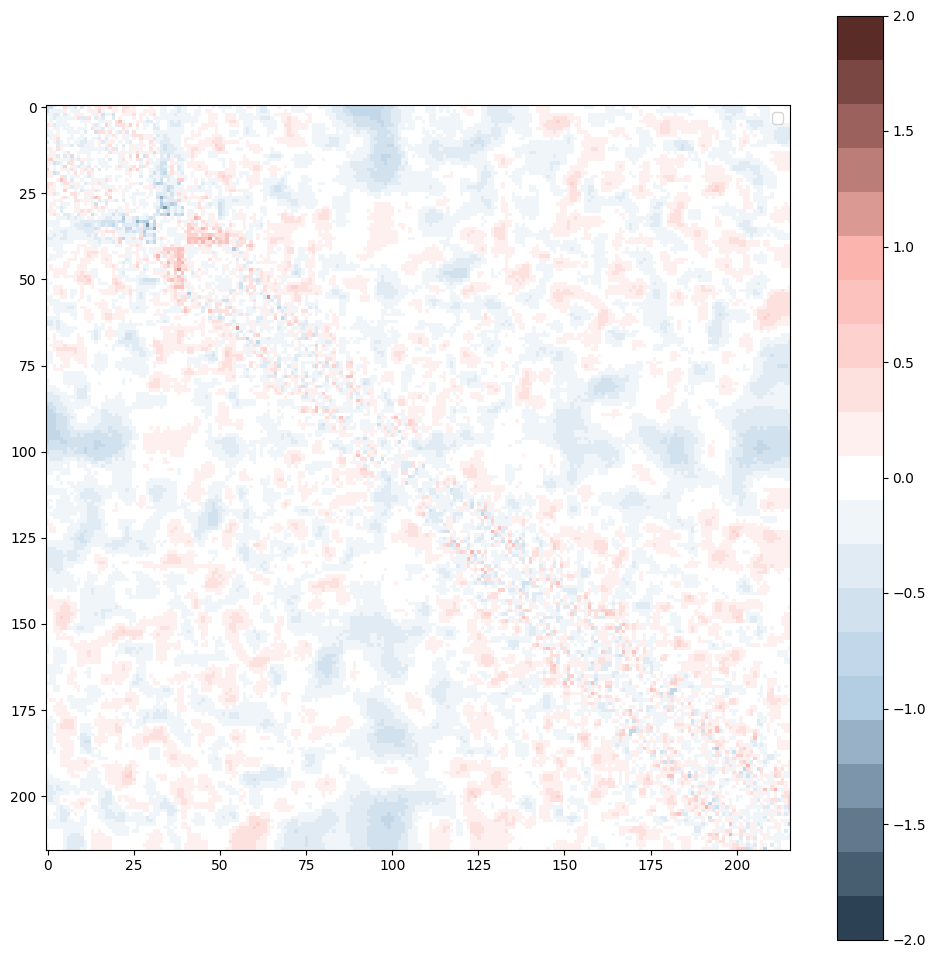

In [17]:
img_list = []
for i in range(n_iterations):
    new_points, new_data = serp_list[i]
    data1, data2 = new_data.T
    logratio = np.log2((data1)/(data2))

    logratio -= np.nanmean(logratio[~np.isinf(logratio)])

    raster_img = rasterized_serpentine(new_points, logratio, A.shape, triangular)
    img_list.append(raster_img)
    plt.close()

superposed_img = np.nanmean(img_list, axis=0)

superposed_img[np.triu_indices(superposed_img.shape[0])] = superposed_img.T[np.triu_indices(superposed_img.shape[0])]

plt.figure(figsize=(12,12))
plt.imshow(superposed_img, cmap=custom_cm, vmin=-2, vmax=2, interpolation='none')

plt.colorbar()
plt.legend("Serpentine 2.0")
plt.show()

In [17]:
np.savetxt("voronoi.csv", superposed_img, delimiter=",")

In [18]:
sA, sB, sK = sp.serpentin_binning(dense_A, dense_B, threshold=21, minthreshold=20, verbose=False, iterations=20, parallel=False)

In [19]:
np.savetxt("serpentine.csv", -(sK - np.nanmean(sK[np.abs(sK)!=np.inf])), delimiter=",")

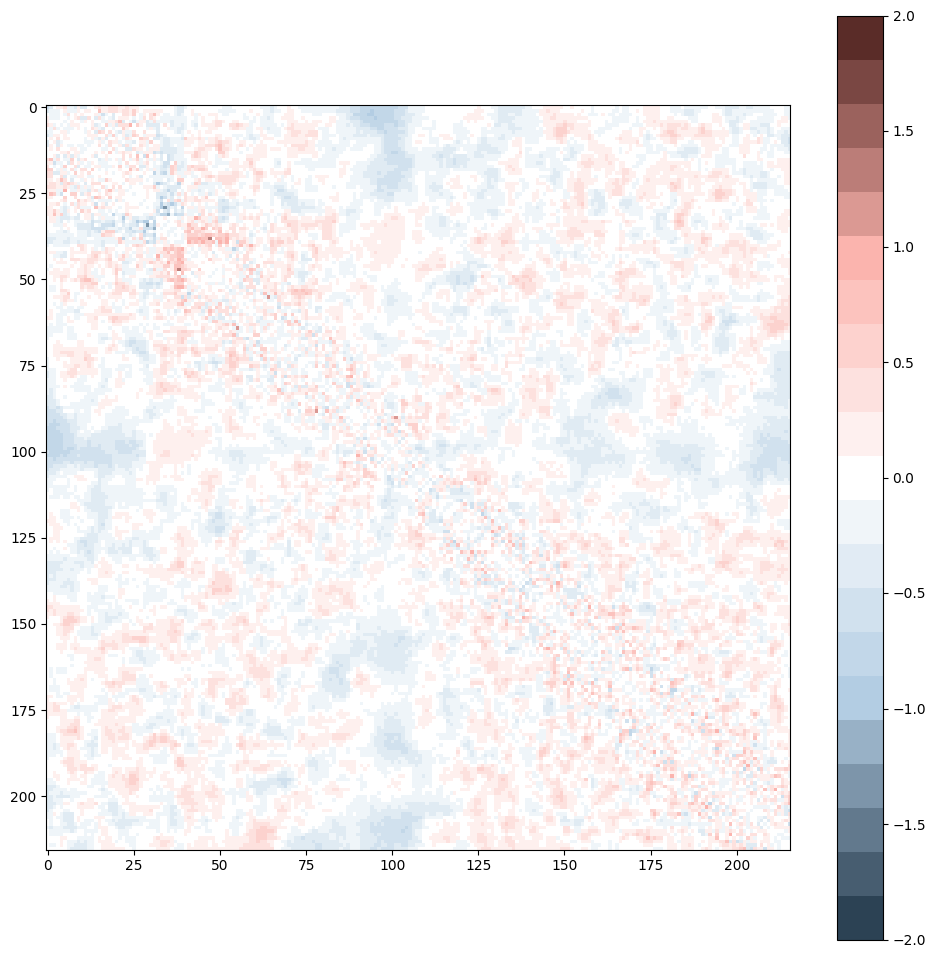

In [20]:
plt.figure(figsize=(12,12))
sp.dshow(-sK, -np.nanmean(sK[np.abs(sK)!=np.inf]), limit=2)

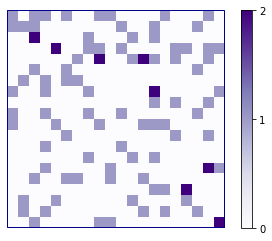

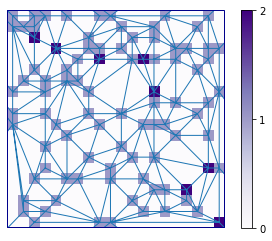

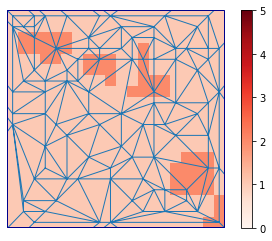

In [66]:
np.random.seed(0)
fake_shape = (20,20)
fake_coverage = 100

fake_A = np.zeros(fake_shape, dtype=np.int32)
fake_B = np.zeros(fake_shape, dtype=np.int32)

for i in range(fake_coverage):
    fake_A[np.random.randint(0, fake_shape[0]), np.random.randint(0, fake_shape[1])] += 1
    fake_B[np.random.randint(0, fake_shape[0]), np.random.randint(0, fake_shape[1])] += 1
# # Generate fake 10x10 matrix for serpentine binning
# fake_A = np.random.randint(0, 100, size=fake_shape)
# fake_B = np.random.randint(0, 100, size=fake_shape)

triangular = False
if triangular is True:
    fake_A = np.triu(fake_A)

fake_B = np.copy(fake_A)

plt.figure()
img = plt.imshow(fake_A.T, cmap='Purples')
plt.xlim((-.5, fake_A.shape[1] - .5))
plt.ylim((fake_A.shape[0] - .5, -.5))

plt.colorbar(ticks=[0,1,2])
plt.axis('off')
plt.gca().add_patch( Rectangle((-.5, -.5),
                        19.9, 19.9,
                        fc ='none', 
                        ec ='darkblue',
                        lw = 1) )

plt.savefig("serpentine/original.png")
plt.show()

# The input of the binning function, a list of csr_matrices and a threshold
fake_Q = [fake_A, fake_B]
fake_threshold = 5

# Find all points
fake_S = sparse.coo_matrix(sum(fake_Q))
fake_S.sum_duplicates()

# The coo-matrix that we are really going to use
fake_points = np.stack((fake_S.row, fake_S.col)).T
fake_data = np.fromiter(
    (M[i,j] for M in fake_Q for i,j in fake_points)
    , dtype=fake_S.dtype).reshape(2, fake_points.shape[0]).T

fake_points, fake_data = add_points_infinity(fake_points, fake_data, fake_A.shape)

# Find the Delaunay graph
fake_tri = Delaunay(fake_points)
fake_indptr, fake_neighv = fake_tri.vertex_neighbor_vertices

plt.figure()
img = plt.imshow(fake_A.T, cmap='Purples')
plt.triplot(fake_points[:,0], fake_points[:,1], fake_tri.simplices, markersize=1, linewidth=1)

plt.xlim((-.5, fake_A.shape[1] - .5))
plt.ylim((fake_A.shape[0] - .5, -.5))

plt.colorbar(ticks=[0,1,2])
plt.axis('off')
plt.gca().add_patch( Rectangle((-.5, -.5),
                        19.9, 19.9,
                        fc ='none', 
                        ec ='darkblue',
                        lw = 1) )

plt.savefig("serpentine/original_delaunay.png")
plt.show()


img = rasterized_serpentine(fake_points, fake_data[:,0], fake_A.shape, triangular)
plt.imshow(img, cmap='Reds', interpolation='none', vmin = 0, vmax=fake_threshold) 
plt.colorbar()

# plot points coordinates from points[k] with green markers
#plt.scatter(pointsimg[:,0], pointsimg[:,1], c='b', s=5)

plt.triplot(fake_points[:,0], fake_points[:,1], fake_tri.simplices, markersize=1, linewidth=1)
plt.xlim((-.5, fake_A.shape[0] - .5))
plt.ylim((fake_A.shape[1] - .5, -.5))

plt.axis('off')
plt.gca().add_patch( Rectangle((-.5, -.5),
                        19.9, 19.9,
                        fc ='none', 
                        ec ='darkblue',
                        lw = 1) )

plt.savefig("serpentine/original_delaunay_voronoi.png")
plt.show()




# run voroserp on fake data, exporting images
os.system("rm serpentine/*.png")
voroserp(fake_points, fake_data, shape=fake_A.shape, indptr=fake_indptr, neighv=fake_neighv, threshold = fake_threshold, maxiter = 100000, imgprefix="serpentine", triangular=triangular);

In [68]:
os.system('convert -delay 10 -loop 0 serpentine/*.png serpentine/animation.gif')

0

In [37]:
jupiter = plt.imread("jupiter.png").sum(axis=2)
curie = plt.imread("curie.png").sum(axis=2)

In [38]:

min_dim = min(curie.shape[0], curie.shape[1])
curie = curie[-min_dim:, -min_dim:]
import cv2
# resize curie image to jupiter'S
curie = cv2.resize(curie, (jupiter.shape[0], jupiter.shape[1]))

In [39]:
curie /= np.nanmean(curie)
jupiter *= 10
jupiter = jupiter.astype(np.int32)

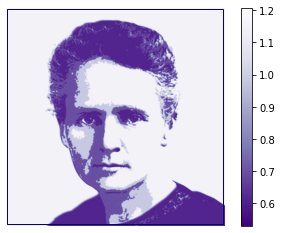

(650, 650)
(650, 650)


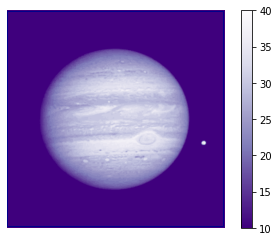

In [51]:
plt.imshow(curie, cmap='Purples_r')
plt.axis('off')
plt.gca().add_patch( Rectangle((0, 0),
                        curie.shape[0]-5, curie.shape[1]-5,
                        fc ='none', 
                        ec ='darkblue',
                        lw = 1) )

plt.colorbar()
plt.show()
print(jupiter.shape)
print(curie.shape)
plt.imshow(jupiter, cmap='Purples_r')
plt.axis('off')
plt.gca().add_patch( Rectangle((0, 0),
                        curie.shape[0]-5, curie.shape[1]-5,
                        fc ='none', 
                        ec ='darkblue',
                        lw = 1) )
plt.colorbar()

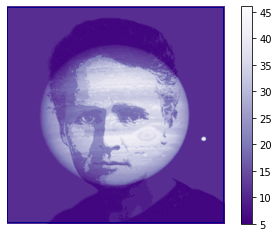

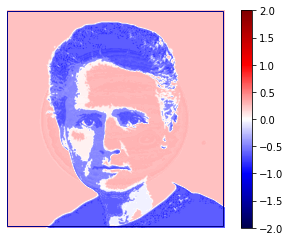

In [56]:
cutimes = (curie*jupiter).astype(jupiter.dtype)
plt.imshow(cutimes, cmap='Purples_r')

plt.axis('off')
plt.gca().add_patch( Rectangle((0, 0),
                        curie.shape[0]-5, curie.shape[1]-5,
                        fc ='none', 
                        ec ='darkblue',
                        lw = 1) )

plt.colorbar()
plt.show()

lograt = np.log2(cutimes/jupiter)
plt.imshow(lograt - np.nanmean(lograt), cmap="seismic", vmin=-2, vmax=2)

plt.axis('off')
plt.gca().add_patch( Rectangle((0, 0),
                        curie.shape[0]-5, curie.shape[1]-5,
                        fc ='none', 
                        ec ='darkblue',
                        lw = 1) )

plt.colorbar()

In [35]:
from scipy.sparse import csr_matrix

def subsample_contacts(M, prop):
    """
    Bootstrap sampling of contacts in a sparse Hi-C map.
    Parameters
    ----------
    M : scipy.sparse.csr_matrix
        The input Hi-C contact map in sparse format.
    prop : float
        The proportion of contacts to sample.
    Returns
    -------
    scipy.sparse.csr_matrix
        A new matrix with a fraction of the original contacts.
    """
    # NOTE: RAM usage vs speed could be balanced by flushing
    # dictionary and recomputing cumsum a given number of times.

    if prop > 1 or prop < 0:
        raise ValueError(
            "The proportion of contacts to sample must be between 0 and 1."
        )
    # Only work with non-zero data of matrices
    O = csr_matrix(M).data
    S = O.copy()
    # Match cell idx to cumulative number of contacts
    cum_sum = np.cumsum(O)
    # Total number of contacts to remove
    tot_contacts = int(max(cum_sum))
    n_remove = int((1 - prop) * tot_contacts)
    # Store contacts that have already been removed
    removed = {}

    for _ in range(n_remove):
        to_remove = np.random.randint(tot_contacts)
        while to_remove in removed:
            to_remove = np.random.randint(tot_contacts)
        # Find idx of cell to deplete and deplete it
        removed[to_remove] = np.searchsorted(cum_sum, to_remove)
        S[removed[to_remove]] -= 1

    return csr_matrix((S, (M.row, M.col)), shape=(M.shape[0], M.shape[1]))
     

In [36]:
print(np.sum(cutimes))

np.sum(cutimes/jupiter)

6424844


406345.1026147158

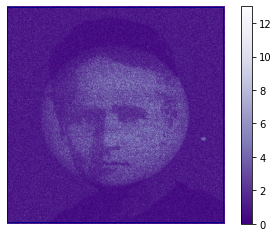

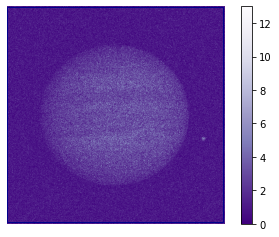

642876 1.5216


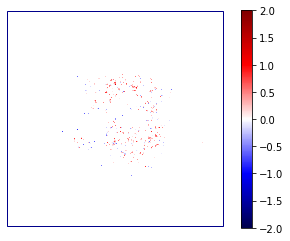

In [60]:
sub_factor = 10

sub_cutimes = np.random.poisson(lam=cutimes/sub_factor)
sub_jup = np.random.poisson(lam=jupiter/sub_factor)

plt.imshow(sub_cutimes, cmap='Purples_r')
plt.colorbar()

plt.axis('off')
plt.gca().add_patch( Rectangle((0, 0),
                        curie.shape[0]-5, curie.shape[1]-5,
                        fc ='none', 
                        ec ='darkblue',
                        lw = 1) )

plt.show()

plt.imshow(sub_jup, cmap='Purples_r')
plt.colorbar()

plt.axis('off')
plt.gca().add_patch( Rectangle((0, 0),
                        curie.shape[0]-5, curie.shape[1]-5,
                        fc ='none', 
                        ec ='darkblue',
                        lw = 1) )

plt.show()

lograt = np.log2(sub_cutimes/sub_jup)
plt.imshow(lograt - np.nanmean(lograt[~np.isinf(lograt)]), cmap="seismic", vmin=-2, vmax=2)

plt.axis('off')
plt.gca().add_patch( Rectangle((0, 0),
                        curie.shape[0]-5, curie.shape[1]-5,
                        fc ='none', 
                        ec ='darkblue',
                        lw = 1) )

plt.colorbar()

print(np.sum(sub_cutimes), np.mean(sub_cutimes))

In [42]:
sub_cutimes.shape

(650, 650)

In [62]:
# The input of the binning function, a list of csr_matrices and a threshold
curpiter = [sub_cutimes, sub_jup]
threshold = 20

# Find all points
S = sparse.coo_matrix(sum(curpiter))
S.sum_duplicates()

# The coo-matrix that we are really going to use
points = np.stack((S.row, S.col)).T
data = np.fromiter(
    (M[i,j] for M in curpiter for i,j in points)
    , dtype=S.dtype).reshape(2, points.shape[0]).T

# Add points at infinity
points, data = add_points_infinity(points, data, sub_cutimes.shape)

# Find the Delaunay graph
tri = Delaunay(points)
indptr, neighv = tri.vertex_neighbor_vertices

n_iterations = 5
serp_list = []
for i in range(n_iterations):
    myvoroserp = voroserp(points, data, indptr=indptr, neighv=neighv, threshold = threshold, maxiter = 100000, shape=sub_cutimes.shape)
    print(i)
    serp_list.append(myvoroserp)

img_list = []
for i in range(n_iterations):
    new_points, new_data = serp_list[i]
    data1, data2 = new_data.T
    logratio = np.log2((data1)/(data2))

    logratio -= np.nanmean(logratio)

    img_list.append(rasterized_serpentine(new_points, logratio, sub_cutimes.shape, False))
    plt.close()

superposed_img = np.nanmean(img_list, axis=0)

0
1
2
3
4


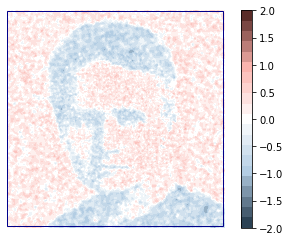

In [65]:
plt.imshow(superposed_img.T - np.nanmean(superposed_img[~np.isinf(superposed_img)]), cmap=custom_cm, vmin=-2, vmax=2)
plt.colorbar()
plt.axis('off')
plt.gca().add_patch( Rectangle((0, 0),
                        curie.shape[0]-5, curie.shape[1]-5,
                        fc ='none', 
                        ec ='darkblue',
                        lw = 1))
plt.show()

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from hicexplorer import hicMatrix as hcm
#import hicexplorer.hicPlotter as hcp

# Define the datasets to download (pairs of Hi-C datasets)
# Each dataset pair is annotated with its biological condition and provenance
datasets = [
    # Differentiated vs. Undifferentiated HUES8 cells - Focusing on Chromosome X
    ('4DNESW9GVC97', '4DNESDO2ZYBM', 'Differentiated vs. Undifferentiated HUES8 Cells', 'chrX'),
    # TCon vs. Treg DSM - Focusing on Chromosome X
    ('4DNESABJHVOM', '4DNES2H8V8YZ', 'TCon (Spleen) vs. Treg DSM - WT Control', 'chrX'),
    # Double-Negative vs. CD8+ Single Positive Thymocyte - Focusing on Chromosome X
#    ('4DNESXXKSOZ8', '4DNESJWSHRA5', 'Double-Negative Alpha-Beta Thymocyte vs. CD8+ Single Positive', 'chrX'),
    # CD4+ Single Positive Thymocyte vs. CD25+ Treg Precursor - Focusing on Chromosome X
#    ('4DNESXRJGZF3', '4DNES673RT2N', 'CD4+ Single Positive vs. CD25+ Treg Precursor', 'chrX'),
    # Foxp3-Low Treg Precursor vs. Foxp3 Treg Precursor - Focusing on Chromosome X
#    ('4DNES41HIROS', '4DNES3WD7MCQ', 'Foxp3-Low Treg Precursor vs. Foxp3 Treg Precursor', 'chrX')
]

def download_data(dataset_id):
    url = f'https://data.4dnucleome.org/files-processed/{dataset_id}/@@download/{dataset_id}.hic'
    os.system(f'wget {url} -O {dataset_id}.hic')

def load_and_process_data(dataset_id):
    hic_matrix = hcm.load_hic_matrix(f'{dataset_id}.hic')
    matrix = hic_matrix.getMatrix().toarray()
    return np.log1p(matrix)

def plot_contact_maps(map1, map2, title):
    ratio = map1 / map2
    plt.imshow(ratio, cmap='bwr', vmin=0.5, vmax=2)
    plt.colorbar()
    plt.title(title)
    plt.show()

for dataset_pair in datasets:
    dataset1, dataset2, condition, region = dataset_pair
    download_data(dataset1)
    download_data(dataset2)

    data1 = load_and_process_data(dataset1, region)
    data2 = load_and_process_data(dataset2, region)
    plot_contact_maps(data1, data2, f'Log Ratio: {dataset1} vs {dataset2} ({condition})')



ImportError: cannot import name 'hicMatrix' from 'hicexplorer' (/home/cig/.virtualenvs/rsgenv/lib/python3.10/site-packages/hicexplorer/__init__.py)